# Inferencia con API - Get Data a Servidor ThingsBoard

In [ ]:
# Importar librerías necesarias
import numpy as np
import requests
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from datetime import datetime
from colorama import Fore, init
import joblib
import os
from tensorflow.keras.layers import GRU
from scipy.stats import kurtosis, skew
import sys

# Definir una función "custom" para GRU que ignore el argumento time_major
def custom_gru(*args, **kwargs):
    kwargs.pop('time_major', None)  # Elimina time_major si existe
    return GRU(*args, **kwargs)

# Inicializa colorama para impresión en consola
init(autoreset=True)

# =============================================================================
# CONFIGURACIÓN
# =============================================================================

# Datos de acceso y configuración de ThingsBoard
thingsboard_host = "http://192.168.5.110:8080"
device_id = "0b1f4a50-f702-11ef-872a-7bb457f6d5f9"
admin_username = "tenant@thingsboard.org"
admin_password = "tenant"

# Definir sensores disponibles
sensor_keys = ["Vibracion", "Corriente"]

# Rutas al modelo y scaler (guardado en la carpeta "modelos")
MODEL_PATH = "modelos/9_Vibracion_GRU_128_64_32_p96993.h5"
MODEL_TYPE = "LSTM"  # Tipo de modelo: "LSTM" o "GRU"
SCALER_PATH = "modelos/scaler.pkl"

# Parámetros para evaluar la predicción (error absoluto)
ERROR_ABS_THRESHOLD = 1.0      # Error absoluto mínimo para considerar anomalía
VENTANA_TIEMPO = 5             # Número de muestras consecutivas a evaluar
CANTIDAD_FALLOS = 3            # Mínimo número de fallos en la ventana para emitir alerta
VENTANA_GRAFICA = 30           # Número de muestras a mostrar en la gráfica

# Número de muestras para la secuencia de entrada (600) y una adicional para comparar
NUM_TIMESTEPS = 600

# Contador de "ok"
cont_ok = 30
move = ""
last_status = ""
err_th_counter = ""
scaler = None

# =============================================================================
# FUNCIONES DE ACCESO A THINGSBOARD
# =============================================================================

def get_token(thingsboard_host, admin_username, admin_password):
    url = f"{thingsboard_host}/api/auth/login"
    payload = {"username": admin_username, "password": admin_password}
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        return response.json().get("token")
    return None

def obtener_datos_thingsboard(thingsboard_host, token, device_id, keys):
    """
    Consulta la API de ThingsBoard para obtener los datos de los últimos 10 minutos.
    """
    keys_str = ",".join(keys)
    now = int(datetime.now().timestamp() * 1000)
    before = now - 1000 * 60 * 10  # Hace 10 minutos
    url = f"{thingsboard_host}/api/plugins/telemetry/DEVICE/{device_id}/values/timeseries"
    params = {"keys": keys_str, "startTs": before, "endTs": now, "limit": 1000}
    headers = {"X-Authorization": f"Bearer {token}"}
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=5)
        response.raise_for_status()
        datos = response.json()
        return datos
    except Exception as e:
        print("Error al obtener datos de ThingsBoard:", e)
        return None

# =============================================================================
# MÉTODOS PARA PROCESAR Y REALIZAR PREDICCIÓN
# =============================================================================

def procesar_y_predecir_sensor(datos, modelo, sensor_key):
    """
    Extrae los datos de los últimos 10 minutos para el sensor indicado, 
    ordena cronológicamente y toma NUM_TIMESTEPS+1 muestras.
    Usa las primeras NUM_TIMESTEPS muestras como secuencia de entrada (forma: [1, NUM_TIMESTEPS, 1]) 
    para predecir la siguiente muestra, que se utiliza como valor real para comparar.
    
    Retorna:
      prediccion: Valor predicho (escala original).
      sensor_value: Valor real (última muestra, escala original).
    """
    try:
        # Extraer y ordenar los datos del sensor
        datos_sensor = datos[sensor_key]
        datos_sensor = sorted(datos_sensor, key=lambda x: x["ts"])
        
        # Verificar que se tengan al menos NUM_TIMESTEPS+1 muestras
        if len(datos_sensor) < NUM_TIMESTEPS + 1:
            raise ValueError(f"Se requieren al menos {NUM_TIMESTEPS + 1} muestras, se encontraron {len(datos_sensor)}")
        
        # Tomar las últimas NUM_TIMESTEPS+1 muestras
        ultimas_muestras = datos_sensor[-(NUM_TIMESTEPS + 1):]
        # Extraer los valores reales
        valores = np.array([float(muestra["value"]) for muestra in ultimas_muestras])
        
        # La secuencia de entrada son las primeras NUM_TIMESTEPS muestras
        secuencia_entrada = valores[:-1]
        # El valor real a predecir es la última muestra
        sensor_value = valores[-1]
        
        # Escalar la secuencia de entrada
        secuencia_scaled = scaler.transform(secuencia_entrada.reshape(-1, 1))
        # Preparar la entrada para el modelo: [1, NUM_TIMESTEPS, 1]
        entrada = secuencia_scaled.reshape(1, NUM_TIMESTEPS, 1)

        # Realizar la predicción (se asume salida de forma (1,1))
        pred_scaled = modelo.predict(entrada, verbose=0)
        
        # Invertir el escalado para obtener la predicción en la escala original
        pred_invertida = scaler.inverse_transform(pred_scaled.reshape(1, -1))
        prediccion = pred_invertida[0,0]
        
        return prediccion, sensor_value
    except Exception as e:
        print("Error durante la predicción:", e)
        return None

def clear_line():
    # Borra la línea actual: retorna al inicio y sobreescribe con espacios (ajusta 100 según el largo esperado)
    sys.stdout.write("\r" + " " * 100 + "\r")
    sys.stdout.flush()
    
def imprimir_alerta(prediccion, sensor_value, fallo_detectado, error):
    """
    Imprime un mensaje con un icono:
      - Si se detecta una anomalía (error en ventana) se imprime en una nueva línea con el icono de alerta en rojo.
      - En condiciones normales, se muestra un mensaje de progreso en la misma línea con el icono de OK.
    """
    global move, last_status, cont_ok, err_th_counter

    icon_err = "⚠️" if error > ERROR_ABS_THRESHOLD else "✅"
    pred_text = f"{prediccion:.4f}" if prediccion < 0 else f" {prediccion:.4f}"
    sensor_text = f"{sensor_value:.4f}" if sensor_value < 0 else f" {sensor_value:.4f}"
    
    mensaje = f"Pred: {pred_text} | Real: {sensor_text} | Err: {error:.4f} / Th: ({ERROR_ABS_THRESHOLD}) {icon_err}"
    if fallo_detectado:
        last_status = "ALERTA"
        move = ""
        print(f"\n🚨 [ALERTA] {mensaje} -> ERROR: Se supera umbral en ventana de {CANTIDAD_FALLOS} en ventana de {VENTANA_TIEMPO} muestras! => ", flush=True)
    else:
        if last_status != "OK":
            last_status = "OK"
            move = ""
            print(f"[DATOS] {mensaje}", end="\r", flush=True)
        else:
            # En llamadas sucesivas, sólo añadimos un punto en la misma línea.
            move += "|"
            car = "\033[K"
            if len(move) > cont_ok:
                car = "\n"
                move = ""
            else:
                clear_line()
            sys.stdout.write(f"{car}[DATOS] {mensaje} ({err_th_counter}) => " + move)
            sys.stdout.flush() # Forzar impresión inmediata
            
# =============================================================================
# VISUALIZACIÓN DE RESULTADOS (últimas 30 muestras)
# =============================================================================

def visualizar_resultados(timestamps, pred_hist, reales, errores):
    # Mostrar solo las últimas {VENTANA_GRAFICA} muestras
    if len(timestamps) > VENTANA_GRAFICA:
        timestamps = timestamps[-VENTANA_GRAFICA:]
        pred_hist = pred_hist[-VENTANA_GRAFICA:]
        reales = reales[-VENTANA_GRAFICA:]
        errores = errores[-VENTANA_GRAFICA:]
        
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, pred_hist, marker='o', linestyle='-', color='blue', label="Predicción")
    plt.plot(timestamps, reales, marker='x', linestyle='--', color='green', label="Valor real")
    plt.plot(timestamps, errores, marker='s', linestyle=':', color='red', label="Error absoluto")
    plt.axhline(y=ERROR_ABS_THRESHOLD, color='purple', linestyle='--', label=f"Umbral error = {ERROR_ABS_THRESHOLD}")
    plt.title("Evolución de predicción, valor real y error (últimas 30 muestras)")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor / Error")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =============================================================================
# FUNCIÓN PRINCIPAL
# =============================================================================

def main(sensor_monitor):
  
    auth_token = get_token(thingsboard_host, admin_username, admin_password)
    if auth_token is None:
        print("Error: No se pudo obtener el token de autenticación.")
        return
    print("Token obtenido correctamente.")
    
    global err_th_counter, scaler
    
    predicciones_hist = []
    errores_hist = []
    timestamps = []
    valores_reales = []
    
    # =============================================================================
    # CARGAR MODELO Y SCALER
    # =============================================================================

    print("Cargando el scaler...")
    scaler = joblib.load(SCALER_PATH)
    print("Scaler cargado correctamente.")
    
    print("Cargando el modelo LSTM/GRU...")
    if MODEL_TYPE == "LSTM":
        modelo = load_model(MODEL_PATH)
    else:            
        modelo = load_model(MODEL_PATH, custom_objects={'GRU': custom_gru})
    print("Modelo cargado correctamente.")
    
    try:
        while True:
            datos = obtener_datos_thingsboard(thingsboard_host, auth_token, device_id, sensor_keys)
            if datos is None:
                print("No se pudieron obtener datos, reintentando...")
                continue
            
            resultado = procesar_y_predecir_sensor(datos, modelo, sensor_monitor)
            
            if resultado is None:
                print("Error en la predicción, reintentando...")
                continue

            prediccion, sensor_value = resultado
            error = abs(sensor_value - prediccion)
            errores_hist.append(error)
            predicciones_hist.append(prediccion)
            valores_reales.append(sensor_value)
            timestamps.append(datetime.now().strftime("%H:%M:%S"))
            
            # Verificar si hay al menos 1 error en la ventana actual
            #ventana_actual_real = np.array(valores_reales[-VENTANA_TIEMPO:])
            #ventana_actual_pred = np.array(predicciones_hist[-VENTANA_TIEMPO:])
            ventana_actual_error = np.array(errores_hist[-VENTANA_TIEMPO:])
            
            fallos = np.sum(ventana_actual_error >= ERROR_ABS_THRESHOLD)
            #print(ERROR_ABS_THRESHOLD, ventana_actual_real)
            err_th_counter = "⚠️"*fallos
            fallo_detectado = fallos >= CANTIDAD_FALLOS
            
            imprimir_alerta(prediccion, sensor_value, fallo_detectado, error)
            
            # Mostrar la gráfica solo una vez cuando se cumpla la condición en la última ventana
            if fallo_detectado:
                #if not alerta_mostrada:
                    visualizar_resultados(timestamps, predicciones_hist, valores_reales, errores_hist)
                    #alerta_mostrada = True
            #else:
            #    alerta_mostrada = False  # Reiniciar el flag cuando ya no se detecte la condición

            plt.pause(1)
    except KeyboardInterrupt:
        print("\nEjecución terminada por el usuario.")


# Inferencia con API - WebSocket Data a Servidor ThingsBoard

In [ ]:
# Importar librerías necesarias
import numpy as np
import requests
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from datetime import datetime
from colorama import Fore, init
import joblib
import os
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM as _LSTM
from scipy.stats import kurtosis, skew
import sys
import json
import websocket
import warnings

# Ignorar warnings de SSL
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime mensajes INFO y WARNING de TensorFlow

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Definir una función "custom" para GRU que ignore el argumento time_major
def custom_gru(*args, **kwargs):
    kwargs.pop('time_major', None)  # Elimina time_major si existe
    return GRU(*args, **kwargs)



class CustomLSTM(_LSTM):
    @classmethod
    def from_config(cls, config):
        config.pop("time_major", None)  # Remover el argumento no reconocido
        return super().from_config(config)
# Inicializa colorama para impresión en consola
init(autoreset=True)

# =============================================================================
# CONFIGURACIÓN
# =============================================================================

# Datos de acceso y configuración de ThingsBoard
thingsboard_host = "192.168.5.110:8080"  # sin el prefijo http:// para ws
device_id = "0b1f4a50-f702-11ef-872a-7bb457f6d5f9"
admin_username = "tenant@thingsboard.org"
admin_password = "tenant"

# Definir sensores disponibles
sensor_keys = ["Vibracion", "Corriente"]

# Rutas al modelo y scaler (guardado en la carpeta "modelos")
MODEL_PATH = "modelos/9_Vibracion_GRU_128_64_32_p96993.h5"
MODEL_TYPE = "LSTM"  # Tipo de modelo: "LSTM" o "GRU"
SCALER_PATH = "modelos/scaler.pkl"

# Parámetros para evaluar la predicción (error absoluto)
ERROR_ABS_THRESHOLD = 1.0      # Error absoluto mínimo para considerar anomalía
VENTANA_TIEMPO = 5             # Número de muestras consecutivas a evaluar
CANTIDAD_FALLOS = 3            # Mínimo número de fallos en la ventana para emitir alerta
VENTANA_GRAFICA = 30           # Número de muestras a mostrar en la gráfica

# Número de muestras para la secuencia de entrada (600) y una adicional para comparar
NUM_TIMESTEPS = 600

# Variables globales para historial y control
cont_ok = 60
move = ""
last_status = ""
err_th_counter = ""
scaler = None
# Declarar un buffer global para almacenar los datos de cada sensor
buffer_data = {key: [] for key in sensor_keys}
# =============================================================================
# FUNCIONES DE ACCESO A THINGSBOARD (por REST para obtener token)
# =============================================================================

def get_token(thingsboard_host, admin_username, admin_password):
    url = f"http://{thingsboard_host}/api/auth/login"
    payload = {"username": admin_username, "password": admin_password}
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        return response.json().get("token")
    return None

# =============================================================================
# MÉTODOS PARA PROCESAR Y REALIZAR PREDICCIÓN
# =============================================================================

def procesar_y_predecir_sensor(datos, modelo, sensor_key):
    """
    Extrae los datos de la telemetry para el sensor indicado, 
    ordena cronológicamente y toma NUM_TIMESTEPS+1 muestras.
    Usa las primeras NUM_TIMESTEPS muestras como secuencia de entrada para predecir la siguiente muestra.
    
    Retorna:
      prediccion: Valor predicho (escala original).
      sensor_value: Valor real (última muestra, escala original).
    """
    try:
        # Accede a los datos del sensor desde el campo "data"
        datos_sensor = datos.get("data", {}).get(sensor_key)
        if datos_sensor is None:
            raise ValueError(f"No se encontró el sensor {sensor_key} en los datos recibidos.")
        
        # Cada muestra es una lista [timestamp, 'valor'], por lo que se ordena por el primer elemento (timestamp)
        datos_sensor = sorted(datos_sensor, key=lambda x: x[0])
        
        if len(datos_sensor) < NUM_TIMESTEPS + 1:
            raise ValueError(f"Se requieren al menos {NUM_TIMESTEPS + 1} muestras, se encontraron {len(datos_sensor)}")
        
        ultimas_muestras = datos_sensor[-(NUM_TIMESTEPS + 1):]
        # Extraer los valores (el segundo elemento de cada lista) y convertir a float
        valores = np.array([float(muestra[1]) for muestra in ultimas_muestras])
        
        secuencia_entrada = valores[:-1]
        sensor_value = valores[-1]
        
        secuencia_scaled = scaler.transform(secuencia_entrada.reshape(-1, 1))
        entrada = secuencia_scaled.reshape(1, NUM_TIMESTEPS, 1)
        
        pred_scaled = modelo.predict(entrada, verbose=0)
        pred_invertida = scaler.inverse_transform(pred_scaled.reshape(1, -1))
        prediccion = pred_invertida[0, 0]
        
        return prediccion, sensor_value
    except Exception as e:
        print("Error durante la predicción:", e)
        return None


def clear_line():
    sys.stdout.write("\r" + " " * 100 + "\r")
    sys.stdout.flush()
    
def imprimir_alerta(prediccion, sensor_value, fallo_detectado, error):
    global move, last_status, cont_ok, err_th_counter

    icon_err = "⚠️" if error > ERROR_ABS_THRESHOLD else "✅"
    pred_text = f"{prediccion:.4f}" if prediccion < 0 else f" {prediccion:.4f}"
    sensor_text = f"{sensor_value:.4f}" if sensor_value < 0 else f" {sensor_value:.4f}"
    
    mensaje = f"Pred: {pred_text} | Real: {sensor_text} | Err: {error:.4f} / Th: ({ERROR_ABS_THRESHOLD}) {icon_err}"
    if fallo_detectado:
        last_status = "ALERTA"
        move = ""
        print(f"\n🚨 [ALERTA] {mensaje} -> ERROR: Se supera umbral en ventana de {CANTIDAD_FALLOS} en ventana de {VENTANA_TIEMPO} muestras! => ", flush=True)
    else:
        if last_status != "OK":
            last_status = "OK"
            move = ""
            print(f"\n[DATOS] {mensaje} => " + move, end="\r", flush=True)
        else:
            move += "|"
            car = "\033[K"
            clear_line()
            sys.stdout.write(f"{car}[DATOS] {mensaje} ({err_th_counter}) => " + move)
            sys.stdout.flush()
            
            if len(move) == cont_ok:
                last_status = ""

def visualizar_resultados(timestamps, pred_hist, reales, errores):
    # Limitar la ventana de datos
    if len(timestamps) > VENTANA_GRAFICA:
        timestamps = timestamps[-VENTANA_GRAFICA:]
        pred_hist = pred_hist[-VENTANA_GRAFICA:]
        reales = reales[-VENTANA_GRAFICA:]
        errores = errores[-VENTANA_GRAFICA:]
    
    # Convertir los timestamps a objetos datetime
    dt_times = [datetime.strptime(ts, "%H:%M:%S.%f") for ts in timestamps]
    
    plt.figure(figsize=(12, 6))
    # Graficar las líneas sin markers
    plt.plot(dt_times, pred_hist, linestyle='-', color='blue', label="Predicción")
    plt.plot(dt_times, reales, linestyle='--', color='green', label="Valor real")
    plt.plot(dt_times, errores, linestyle=':', color='red', label="Error absoluto")
    plt.axhline(y=ERROR_ABS_THRESHOLD, color='purple', linestyle='--', label=f"Umbral error = {ERROR_ABS_THRESHOLD}")
    plt.title("Evolución de predicción, valor real y error (últimas 30 muestras)")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor / Error")
    
    # Seleccionar índices donde se detecta error (por ejemplo, error >= ERROR_ABS_THRESHOLD)
    error_indices = [i for i, err in enumerate(errores) if err >= ERROR_ABS_THRESHOLD]
    if error_indices:
        error_times = [dt_times[i] for i in error_indices]
        error_pred = [pred_hist[i] for i in error_indices]
        error_real = [reales[i] for i in error_indices]
        error_val = [errores[i] for i in error_indices]
        # Sobreponer markers en los puntos de error
        plt.scatter(error_times, error_pred, marker='o', color='blue')
        plt.scatter(error_times, error_real, marker='x', color='green')
        plt.scatter(error_times, error_val, marker='s', color='red')
    
    # Configurar los ticks del eje X: mostrar una etiqueta cada 5 segundos
    tick_positions = []
    tick_labels = []
    if dt_times:
        last_tick = dt_times[0]
        tick_positions.append(last_tick)
        tick_labels.append(last_tick.strftime("%H:%M:%S"))
        for dt in dt_times[1:]:
            if (dt - last_tick).total_seconds() >= 5:
                tick_positions.append(dt)
                tick_labels.append(dt.strftime("%H:%M:%S"))
                last_tick = dt

    plt.xticks(tick_positions, tick_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# =============================================================================
# FUNCIÓN PRINCIPAL CON WEBSOCKET
# =============================================================================

def main(sensor_monitor):
    # Obtener token vía REST
    auth_token = get_token(thingsboard_host, admin_username, admin_password)
    if auth_token is None:
        print("Error: No se pudo obtener el token de autenticación.")
        return
    print("Token obtenido correctamente.")
    
    global scaler
    predicciones_hist = []
    errores_hist = []
    timestamps = []
    valores_reales = []
    
    # Cargar scaler y modelo
    print("Cargando el scaler...")
    scaler = joblib.load(SCALER_PATH)
    print("Scaler cargado correctamente.")
    
    print("Cargando el modelo LSTM/GRU...")
    if MODEL_TYPE == "LSTM":
        modelo = load_model(MODEL_PATH, custom_objects={'LSTM': CustomLSTM})
    else:            
        modelo = load_model(MODEL_PATH, custom_objects={'GRU': custom_gru})
    print("Modelo cargado correctamente.")
    
    # Construir la URL del WebSocket (usando ws://)
    ws_url = f"ws://{thingsboard_host}/api/ws/plugins/telemetry?token={auth_token}"
    
    # Definir callbacks del websocket
    def on_open(ws):
        print("WebSocket conectado.")
        subscription_message = {
            "tsSubCmds": [{
                "entityType": "DEVICE",
                "entityId": device_id,
                "scope": "LATEST_TELEMETRY",
                "cmdId": 1,
                "keys": ",".join(sensor_keys)
            }],
            "historyCmds": []
        }
        ws.send(json.dumps(subscription_message))
        #print("Suscripción enviada:", subscription_message)
    
    
    contador_muestras = 0
    
    def on_message(ws, message):
        nonlocal predicciones_hist, errores_hist, timestamps, valores_reales, contador_muestras
        global buffer_data
        try:
            datos = json.loads(message)
            # Actualizar el buffer con los nuevos datos recibidos
            for sensor in sensor_keys:
                nuevos = datos.get("data", {}).get(sensor, [])
                for muestra in nuevos:
                    try:
                        valor = float(muestra[1])
                        buffer_data[sensor].append(valor)
                    except Exception as ex:
                        print(f"Error convirtiendo valor para {sensor}: {ex}")
                    # Mantener solo las últimas NUM_TIMESTEPS+1 muestras
                    if len(buffer_data[sensor]) > NUM_TIMESTEPS + 1:
                        buffer_data[sensor].pop(0)
            
            # Si no hay suficientes datos para el sensor que se está monitoreando, salir
            if len(buffer_data[sensor_monitor]) < NUM_TIMESTEPS + 1:
                #print(f"No hay suficientes datos para predecir para {sensor_monitor}. Recolectando: {len(buffer_data[sensor_monitor])} muestras", end="\r", flush=True)
                clear_line()
                sys.stdout.write(f"No hay suficientes datos para predecir para {sensor_monitor}. Recolectando: {len(buffer_data[sensor_monitor])} muestras")
                sys.stdout.flush()
                return

            # Preparar una estructura similar a la esperada por procesar_y_predecir_sensor
            datos_acumulados = {
                "data": {
                    sensor_monitor: [[0, v] for v in buffer_data[sensor_monitor]]
                }
            }
            resultado = procesar_y_predecir_sensor(datos_acumulados, modelo, sensor_monitor)
            if resultado is None:
                print("Error en la predicción, omitiendo mensaje...")
                return
            
            
            prediccion, sensor_value = resultado
            error = abs(sensor_value - prediccion)
            errores_hist.append(error)
            predicciones_hist.append(prediccion)
            valores_reales.append(sensor_value)
            timestamps.append(datetime.now().strftime("%H:%M:%S.%f"))
            
            ventana_actual_error = np.array(errores_hist[-VENTANA_TIEMPO:])
            fallos = np.sum(ventana_actual_error >= ERROR_ABS_THRESHOLD)
            global err_th_counter
            err_th_counter = "⚠️" * int(fallos)
            fallo_detectado = fallos >= CANTIDAD_FALLOS
            imprimir_alerta(prediccion, sensor_value, fallo_detectado, error)
            
            
            if fallo_detectado and contador_muestras == 0:
                contador_muestras = 1
                visualizar_resultados(timestamps, predicciones_hist, valores_reales, errores_hist)
            
            if 0 < contador_muestras < VENTANA_GRAFICA/2:
                contador_muestras += 1
            else:
                contador_muestras = 0    

        except Exception as e:
            print("Error procesando mensaje:", e)

    
    def on_error(ws, error):
        print("WebSocket error:", error)
    
    def on_close(ws):
        print("WebSocket cerrado.")
    
    # Conectar al WebSocket y entrar en loop
    ws = websocket.WebSocketApp(ws_url,
                                on_open=on_open,
                                on_message=on_message,
                                on_error=on_error,
                                on_close=on_close)
    try:
        ws.run_forever()
    except KeyboardInterrupt:
        print("\nEjecución terminada por el usuario.")


## 1. Conexion con WebSocket y envio de data Prediccion a ThingsBoard

In [1]:
# Importar librerías necesarias
import os
import sys
import json
import numpy as np
import requests
import websocket
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from datetime import datetime
from colorama import init
import joblib
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM as _LSTM

# Ignorar warnings de SSL
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime mensajes INFO y WARNING de TensorFlow

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Definir una función "custom" para GRU que ignore el argumento time_major
def custom_gru(*args, **kwargs):
    kwargs.pop('time_major', None)  # Elimina time_major si existe
    return GRU(*args, **kwargs)

class CustomLSTM(_LSTM):
    @classmethod
    def from_config(cls, config):
        config.pop("time_major", None)  # Remover el argumento no reconocido
        return super().from_config(config)
# Inicializa colorama para impresión en consola
init(autoreset=True)

# =============================================================================
# CONFIGURACIÓN
# =============================================================================

# Datos de acceso y configuración de ThingsBoard
thingsboard_host = "192.168.5.110:8080"  # sin el prefijo http:// para ws
device_id = "0b1f4a50-f702-11ef-872a-7bb457f6d5f9"
admin_username = "tenant@thingsboard.org"
admin_password = "tenant"

# Definir sensores disponibles
sensor_keys = ["Vibracion", "Corriente"]

# Rutas al modelo y scaler (guardado en la carpeta "modelos")
MODEL_PATH = "modelos/9_Vibracion_GRU_128_64_32_p96993.h5"
MODEL_TYPE = "LSTM"  # Tipo de modelo: "LSTM" o "GRU"
SCALER_PATH = "modelos/scaler.pkl"

# Parámetros para evaluar la predicción (error absoluto)
ERROR_ABS_THRESHOLD = 1.0      # Error absoluto mínimo para considerar anomalía
VENTANA_TIEMPO = 5             # Número de muestras consecutivas a evaluar
CANTIDAD_FALLOS = 3            # Mínimo número de fallos en la ventana para emitir alerta

# Número de muestras para la secuencia de entrada (600) y una adicional para comparar
VENTANA_GRAFICA = 300           # Número de muestras a mostrar en la gráfica
NUM_TIMESTEPS = 600

# Variables globales para historial y control
cont_ok = 60
move = ""
last_status = ""
err_th_counter = ""
scaler = None
# Declarar un buffer global para almacenar los datos de cada sensor
buffer_data = {key: [] for key in sensor_keys}

# =============================================================================
# FUNCIONES DE ACCESO A THINGSBOARD (por REST para obtener token)
# =============================================================================

def get_token(thingsboard_host, admin_username, admin_password):
    url = f"http://{thingsboard_host}/api/auth/login"
    payload = {"username": admin_username, "password": admin_password}
    response = requests.post(url, json=payload)
    if response.status_code == 200:
        return response.json().get("token")
    return None

# =============================================================================
# NUEVA FUNCIÓN: ENVÍO DE TELEMETRÍA A THINGSBOARD
# =============================================================================
def enviar_prediccion_thingsboard(pred, error, threshold, wind, max_fails, feature, ts, fails, fallo_detectado):
    """
    Envía la predicción, el error y el threshold al dispositivo "Prediccion_Python"
    utilizando el token: YTSqBDOow3CwjAwAw5J2.
    Las keys del payload son:
        pred_<feature>: la predicción
        error_<feature>: el error
        threshold_<feature>: el threshold configurado
        timestamp: el timestamp de la muestra real,
        fails_<feature>: el número de fallos en la ventana actual
    """
    url = f"http://{thingsboard_host}/api/v1/YTSqBDOow3CwjAwAw5J2/telemetry"
    payload = {
        f"pred_{feature}": str(round(pred, 2)),
        f"error_{feature}": str(round(error, 2)),
        f"threshold_{feature}": str(round(threshold, 2)),
        #"timestamp": ts,
        f"window_{feature}": str(wind),
        f"max_fails_{feature}": str(max_fails),
        f"fails_{feature}": str(round(fails,2)), 
        f"fallo_detectado_{feature}": str(1 if fallo_detectado else 0)
    }
    try:
        r = requests.post(url, json=payload, timeout=5)
        if r.status_code != 200:
            print("\nError al enviar telemetría:", r.text)
            
    except Exception as ex:
        print("\nExcepción al enviar telemetría:", ex)

# =============================================================================
# MÉTODOS PARA PROCESAR Y REALIZAR PREDICCIÓN
# =============================================================================

def procesar_y_predecir_sensor(datos, modelo, sensor_key):
    """
    Extrae los datos de la telemetry para el sensor indicado, 
    ordena cronológicamente y toma NUM_TIMESTEPS+1 muestras.
    Usa las primeras NUM_TIMESTEPS muestras como secuencia de entrada para predecir la siguiente muestra.
    
    Retorna:
      prediccion: Valor predicho (escala original).
      sensor_value: Valor real (última muestra, escala original).
    """
    try:
        # Accede a los datos del sensor desde el campo "data"
        datos_sensor = datos.get("data", {}).get(sensor_key)
        if datos_sensor is None:
            raise ValueError(f"No se encontró el sensor {sensor_key} en los datos recibidos.")
        
        # Cada muestra es una lista [timestamp, 'valor'], por lo que se ordena por el primer elemento (timestamp)
        datos_sensor = sorted(datos_sensor, key=lambda x: x[0])
        
        if len(datos_sensor) < NUM_TIMESTEPS + 1:
            raise ValueError(f"Se requieren al menos {NUM_TIMESTEPS + 1} muestras, se encontraron {len(datos_sensor)}")
        
        ultimas_muestras = datos_sensor[-(NUM_TIMESTEPS + 1):]
        # Extraer los valores (el segundo elemento de cada lista) y convertir a float
        valores = np.array([float(muestra[1]) for muestra in ultimas_muestras])
        
        secuencia_entrada = valores[:-1]
        sensor_value = valores[-1]
        
        secuencia_scaled = scaler.transform(secuencia_entrada.reshape(-1, 1))
        entrada = secuencia_scaled.reshape(1, NUM_TIMESTEPS, 1)
        
        pred_scaled = modelo.predict(entrada, verbose=0)
        pred_invertida = scaler.inverse_transform(pred_scaled.reshape(1, -1))
        prediccion = pred_invertida[0, 0]
        
        return prediccion, sensor_value
    except Exception as e:
        print("Error durante la predicción:", e)
        return None

def clear_line():
    sys.stdout.write("\r" + " " * 100 + "\r")
    sys.stdout.flush()
    
def imprimir_alerta(prediccion, sensor_value, fallo_detectado, error, fallos):
    global move, last_status, cont_ok, err_th_counter

    icon_err = "⚠️" if error > ERROR_ABS_THRESHOLD else "✅"
    pred_text = f"{prediccion:.4f}" if prediccion < 0 else f" {prediccion:.4f}"
    sensor_text = f"{sensor_value:.4f}" if sensor_value < 0 else f" {sensor_value:.4f}"
    
    mensaje = f"Pred: {pred_text} | Real: {sensor_text} | Fails: [{fallos}] | Err: {error:.4f} / Th: ({ERROR_ABS_THRESHOLD}) {icon_err}"
    if fallo_detectado:
        last_status = "ALERTA"
        move = ""
        print(f"\n🚨 [ALERTA] {mensaje} -> ERROR: Se supera umbral en ventana de {CANTIDAD_FALLOS} en Ventana de muestras!", flush=True)
    else:
        if last_status != "OK":
            last_status = "OK"
            move = ""
            print(f"\n[DATOS] {mensaje} => " + move, end="\r", flush=True)
        else:
            move += "|"
            clear_line()
            sys.stdout.write(f"[DATOS] {mensaje} ({err_th_counter}) => " + move)
            sys.stdout.flush()
            if len(move) == cont_ok:
                last_status = ""

def visualizar_resultados(timestamps, pred_hist, reales, errores):
    # Limitar la ventana de datos
    if len(timestamps) > VENTANA_GRAFICA:
        timestamps = timestamps[-VENTANA_GRAFICA:]
        pred_hist = pred_hist[-VENTANA_GRAFICA:]
        reales = reales[-VENTANA_GRAFICA:]
        errores = errores[-VENTANA_GRAFICA:]
    
    # Convertir los timestamps a objetos datetime
    dt_times = [datetime.strptime(ts, "%H:%M:%S.%f") for ts in timestamps]
    
    plt.figure(figsize=(12, 6))
    # Graficar las líneas sin markers
    plt.plot(dt_times, pred_hist, linestyle='-', color='blue', label="Predicción")
    plt.plot(dt_times, reales, linestyle='--', color='green', label="Valor real")
    plt.plot(dt_times, errores, linestyle=':', color='red', label="Error absoluto")
    plt.axhline(y=ERROR_ABS_THRESHOLD, color='purple', linestyle='--', label=f"Umbral error = {ERROR_ABS_THRESHOLD}")
    plt.title("Evolución de predicción, valor real y error (últimas 30 muestras)")
    plt.xlabel("Tiempo")
    plt.ylabel("Valor / Error")
    
    # Configurar los ticks del eje X: mostrar una etiqueta cada 5 segundos
    tick_positions = []
    tick_labels = []
    if dt_times:
        last_tick = dt_times[0]
        tick_positions.append(last_tick)
        tick_labels.append(last_tick.strftime("%H:%M:%S"))
        for dt in dt_times[1:]:
            if (dt - last_tick).total_seconds() >= 5:
                tick_positions.append(dt)
                tick_labels.append(dt.strftime("%H:%M:%S"))
                last_tick = dt
    plt.xticks(tick_positions, tick_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =============================================================================
# FUNCIÓN PRINCIPAL CON WEBSOCKET
# =============================================================================

def main(sensor_monitor):
    auth_token = get_token(thingsboard_host, admin_username, admin_password)
    if auth_token is None:
        print("Error: No se pudo obtener el token de autenticación.")
        return
    print("Token obtenido correctamente.")
    
    global scaler
    predicciones_hist = []
    errores_hist = []
    timestamps = []
    valores_reales = []
    
    print("Cargando el scaler...")
    scaler = joblib.load(SCALER_PATH)
    print("Scaler cargado correctamente.")
    
    print("Cargando el modelo LSTM/GRU...")
    if MODEL_TYPE == "LSTM":
        modelo = load_model(MODEL_PATH, custom_objects={'LSTM': CustomLSTM})
    else:            
        modelo = load_model(MODEL_PATH, custom_objects={'GRU': custom_gru})
    print("Modelo cargado correctamente.")
    
    ws_url = f"ws://{thingsboard_host}/api/ws/plugins/telemetry?token={auth_token}"
    
    global last_graph_sample_index
    last_graph_sample_index = 0
    
    def on_open(ws):
        print("WebSocket conectado.")
        subscription_message = {
            "tsSubCmds": [{
                "entityType": "DEVICE",
                "entityId": device_id,
                "scope": "LATEST_TELEMETRY",
                "cmdId": 1,
                "keys": ",".join(sensor_keys)
            }],
            "historyCmds": []
        }
        ws.send(json.dumps(subscription_message))
    
    contador_muestras = 0
    
    def on_message(ws, message):
        nonlocal predicciones_hist, errores_hist, timestamps, valores_reales, contador_muestras
        global buffer_data
        try:
            datos = json.loads(message)
            for sensor in sensor_keys:
                nuevos = datos.get("data", {}).get(sensor, [])
                for muestra in nuevos:
                    try:
                        valor = float(muestra[1])
                        buffer_data[sensor].append(valor)
                    except Exception as ex:
                        print(f"Error convirtiendo valor para {sensor}: {ex}")
                    if len(buffer_data[sensor]) > NUM_TIMESTEPS + 1:
                        buffer_data[sensor].pop(0)
            
            if len(buffer_data[sensor_monitor]) < NUM_TIMESTEPS + 1:
                clear_line()
                sys.stdout.write(f"No hay suficientes datos para predecir para {sensor_monitor}. Recolectando: {len(buffer_data[sensor_monitor])} muestras")
                sys.stdout.flush()
                return

            datos_acumulados = {
                "data": {
                    sensor_monitor: [[0, v] for v in buffer_data[sensor_monitor]]
                }
            }
            resultado = procesar_y_predecir_sensor(datos_acumulados, modelo, sensor_monitor)
            if resultado is None:
                print("Error en la predicción, omitiendo mensaje...")
                return
            
            prediccion, sensor_value = resultado
            error = abs(sensor_value - prediccion)
            errores_hist.append(error)
            predicciones_hist.append(prediccion)
            valores_reales.append(sensor_value)
            # Se usa el timestamp de la predicción (actual) para alinear con la muestra real
            ts_actual = datetime.now().strftime("%H:%M:%S.%f")
            timestamps.append(ts_actual)
            
            ventana_actual_error = np.array(errores_hist[-VENTANA_TIEMPO:])
            fallos = np.sum(ventana_actual_error >= ERROR_ABS_THRESHOLD)
            global err_th_counter
            err_th_counter = "⚠️" * int(fallos)
            fallo_detectado = fallos >= CANTIDAD_FALLOS
            
            # Enviar telemetría a ThingsBoard con las keys especificadas y el timestamp
            enviar_prediccion_thingsboard(prediccion, error, ERROR_ABS_THRESHOLD, VENTANA_TIEMPO, CANTIDAD_FALLOS, sensor_monitor, ts_actual, fallos, fallo_detectado)
            imprimir_alerta(prediccion, sensor_value, fallo_detectado, error, fallos)
            
            if fallo_detectado and contador_muestras == 0:
                contador_muestras = 1
                visualizar_resultados(timestamps, predicciones_hist, valores_reales, errores_hist)
            
            if 0 < contador_muestras < VENTANA_GRAFICA/2:
                contador_muestras += 1
            else:
                contador_muestras = 0    

        except Exception as e:
            print("Error procesando mensaje:", e)

    def on_error(ws, error):
        print("WebSocket error:", error)
    
    def on_close(ws, close_status_code, close_msg):
        print("WebSocket cerrado.")
    
    ws = websocket.WebSocketApp(ws_url,
                                on_open=on_open,
                                on_message=on_message,
                                on_error=on_error,
                                on_close=on_close)
    try:
        ws.run_forever()
    except KeyboardInterrupt:
        print("\nEjecución terminada por el usuario.")



## 2. Configuramos Monitoreo y Modelo Cargar, luego hacemos inferencia del sensor Vibración. 

Iniciando monitoreo para el sensor: Vibracion
Token obtenido correctamente.
Cargando el scaler...
Scaler cargado correctamente.
Cargando el modelo LSTM/GRU...
Modelo cargado correctamente.
WebSocket conectado.
No hay suficientes datos para predecir para Vibracion. Recolectando: 600 muestras                   
[DATOS] Pred: -0.7661 | Real:  0.2100 | Fails: [4] | Err: 0.9761 / Th: (0.6) ⚠️ (⚠️⚠️⚠️⚠️) => ||||  
🚨 [ALERTA] Pred: -0.6901 | Real:  0.4500 | Fails: [5] | Err: 1.1401 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!


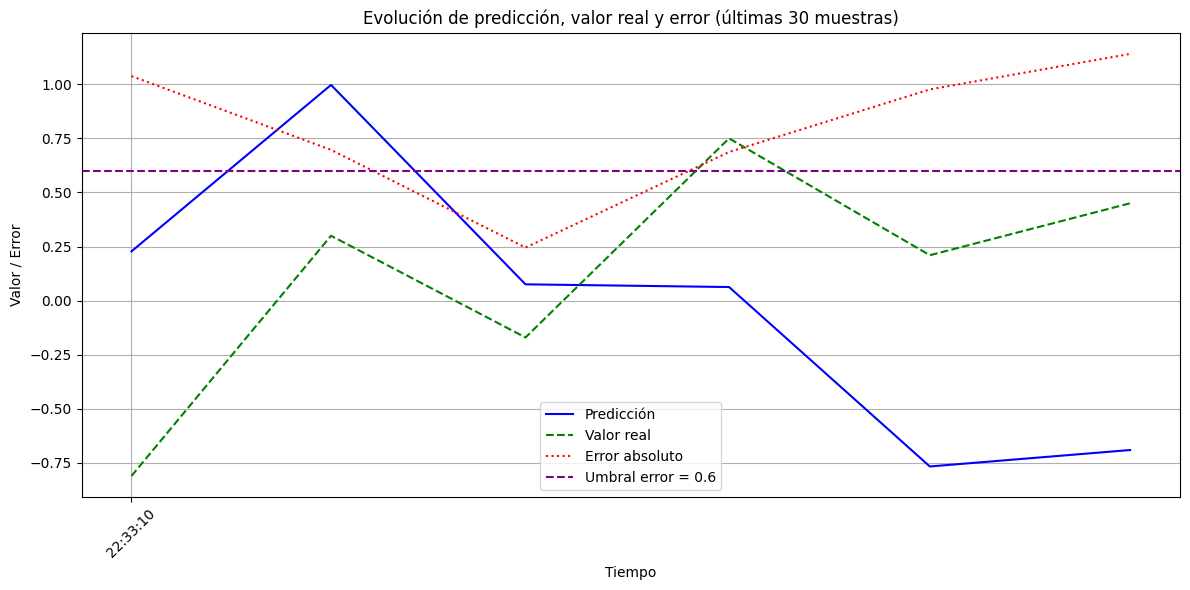


🚨 [ALERTA] Pred: -0.3970 | Real:  0.0000 | Fails: [5] | Err: 0.3970 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.4879 | Real: -0.4500 | Fails: [5] | Err: 0.0379 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.7870 | Real: -0.2900 | Fails: [6] | Err: 1.0770 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.3578 | Real: -0.6200 | Fails: [7] | Err: 0.9778 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.8545 | Real:  0.2300 | Fails: [8] | Err: 0.6245 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.0772 | Real:  0.1300 | Fails: [8] | Err: 0.0528 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.2620 | Real:  0.6500 | Fails: [9] | Err: 0.9120 / Th: (0.6) ⚠️ -> ERROR: Se 

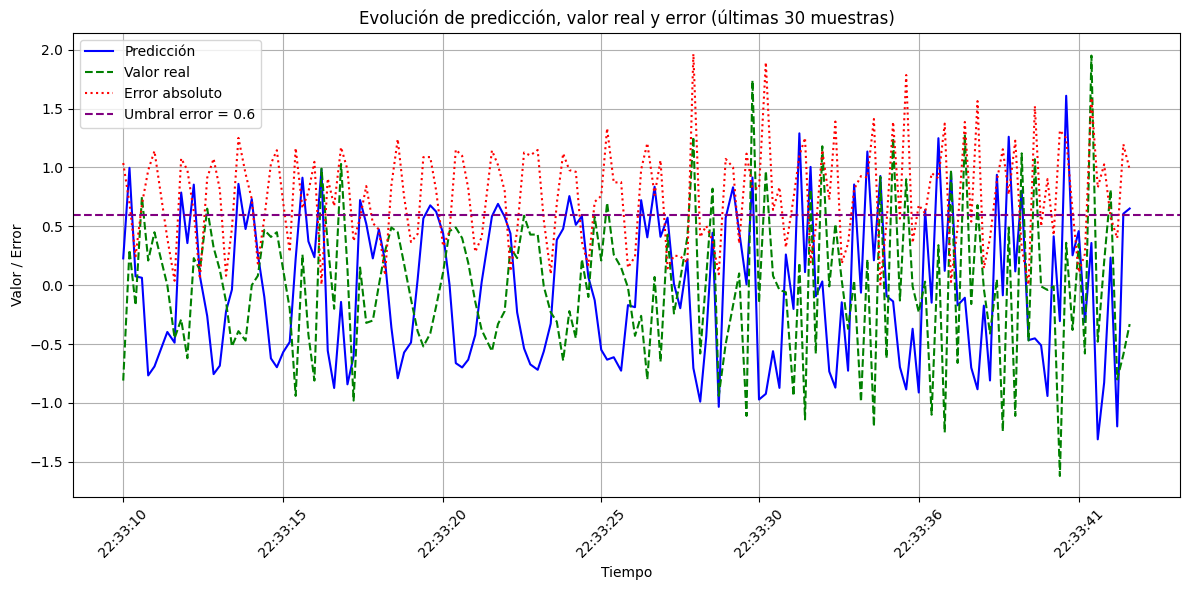


🚨 [ALERTA] Pred:  0.7431 | Real:  0.3500 | Fails: [16] | Err: 0.3931 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.2130 | Real: -0.8900 | Fails: [17] | Err: 0.6770 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.7304 | Real:  1.0000 | Fails: [17] | Err: 0.2696 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.4692 | Real: -0.2200 | Fails: [16] | Err: 0.2492 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.6169 | Real:  1.0100 | Fails: [17] | Err: 1.6269 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.5905 | Real:  0.1000 | Fails: [17] | Err: 0.6905 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.8723 | Real: -0.0700 | Fails: [18] | Err: 0.8023 / Th: (0.6) ⚠️ -> ERR

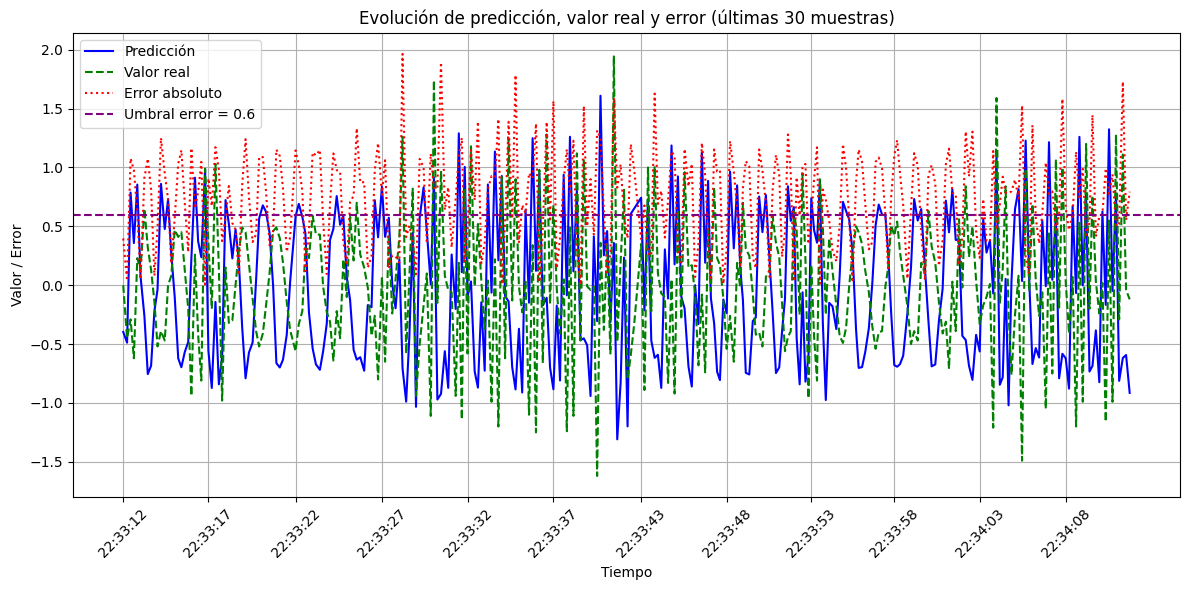


🚨 [ALERTA] Pred:  0.5070 | Real:  0.0400 | Fails: [18] | Err: 0.4670 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.2775 | Real: -1.2500 | Fails: [19] | Err: 0.9725 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  1.4440 | Real:  0.4900 | Fails: [20] | Err: 0.9540 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.0031 | Real: -1.0800 | Fails: [20] | Err: 1.0831 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.9090 | Real:  1.1600 | Fails: [19] | Err: 0.2510 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.6132 | Real: -0.3700 | Fails: [18] | Err: 0.2432 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.4572 | Real:  1.1600 | Fails: [18] | Err: 1.6172 / Th: (0.6) ⚠️ -> ERR

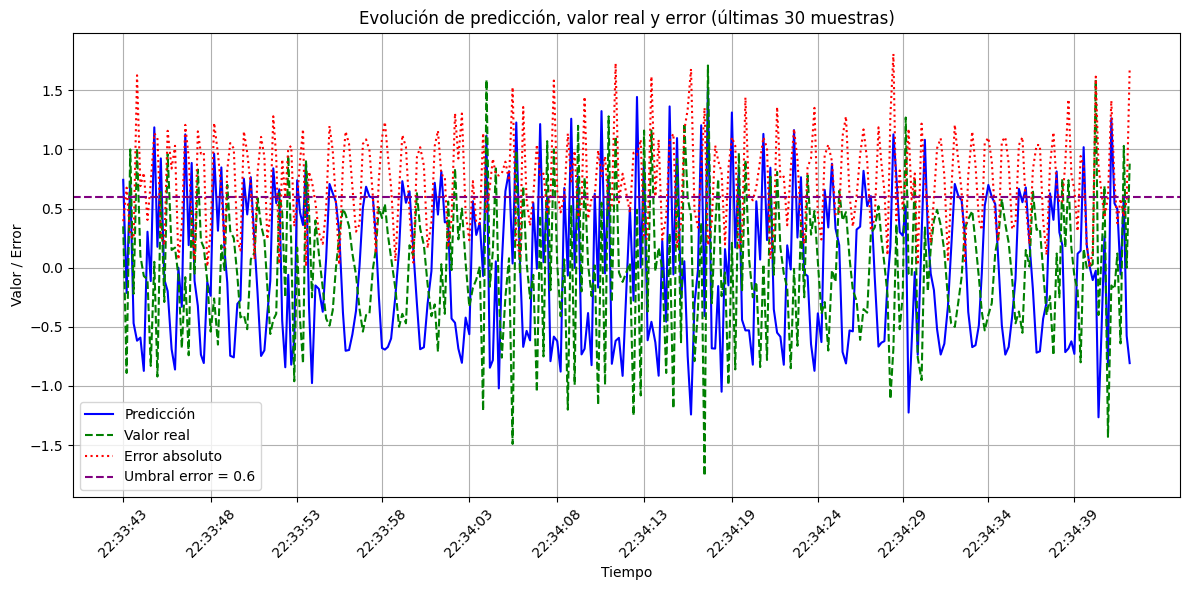


🚨 [ALERTA] Pred: -0.5061 | Real:  0.0400 | Fails: [15] | Err: 0.5461 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.7453 | Real:  0.0500 | Fails: [16] | Err: 0.7953 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.2117 | Real: -0.0700 | Fails: [16] | Err: 0.2817 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred: -0.1494 | Real: -1.0800 | Fails: [16] | Err: 0.9306 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  1.3104 | Real:  0.3900 | Fails: [16] | Err: 0.9204 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.1001 | Real: -0.9200 | Fails: [16] | Err: 1.0201 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 5 en Ventana de muestras!

🚨 [ALERTA] Pred:  0.7925 | Real:  1.0500 | Fails: [16] | Err: 0.2575 / Th: (0.6) ✅ -> ERR

: 

In [ ]:
# Selecciona el sensor a monitorear: "Vibracion" o "Corriente"
sensor_a_monitor = "Vibracion"

# Parámetros para evaluar la predicción (error absoluto)
ERROR_ABS_THRESHOLD = 0.6 # Error absoluto mínimo para considerar anomalía
VENTANA_TIEMPO = 30       # Número de muestras consecutivas a evaluar
CANTIDAD_FALLOS = 5       # Mínimo número de fallos en la ventana para emitir alerta


# Número de muestras para la secuencia de entrada (600) y una adicional para comparar
MODEL_PATH = "modelos/1_Vibracion_LSTM_128_64_32_Ts_60_p128417.h5"
MODEL_TYPE = "LSTM"  # Tipo de modelo: "LSTM" o "GRU"
SCALER_PATH = "modelos/scaler-Vibracion.pkl"

# Ejecuta el monitoreo para el sensor seleccionado
print(f"Iniciando monitoreo para el sensor: {sensor_a_monitor}")
main(sensor_a_monitor)

## 3. Configuramos Monitoreo y Modelo Cargar, luego hacemos inferencia del sensor Corriente. 

Iniciando monitoreo para el sensor: Corriente
Token obtenido correctamente.
Cargando el scaler...
Scaler cargado correctamente.
Cargando el modelo LSTM/GRU...
Modelo cargado correctamente.
WebSocket conectado.
No hay suficientes datos para predecir para Corriente. Recolectando: 600 muestras                   
[DATOS] Pred:  11.5244 | Real:  11.4200 | Fails: [0] | Err: 0.1044 / Th: (0.6) ✅ () => ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[DATOS] Pred:  11.8420 | Real:  11.8200 | Fails: [0] | Err: 0.0220 / Th: (0.6) ✅ () => ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[DATOS] Pred:  12.3088 | Real:  12.2900 | Fails: [0] | Err: 0.0188 / Th: (0.6) ✅ () => ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[DATOS] Pred:  12.5749 | Real:  12.5800 | Fails: [0] | Err: 0.0051 / Th: (0.6) ✅ () => ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[DATOS] Pred:  12.9534 | Real:  12.8600 | Fails: [0] | Err: 0.0934 / Th: (0.6) ✅ () => ||||||||||

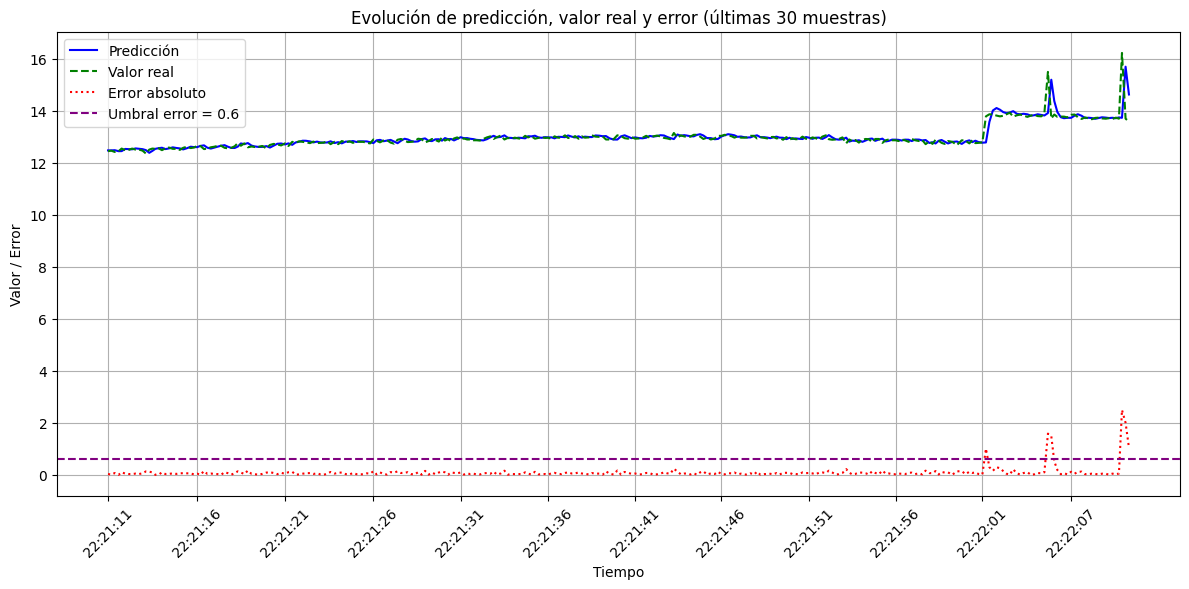


🚨 [ALERTA] Pred:  13.8035 | Real:  13.6100 | Fails: [6] | Err: 0.1935 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.5232 | Real:  13.6400 | Fails: [6] | Err: 0.1168 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.5074 | Real:  13.7300 | Fails: [6] | Err: 0.2226 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.6200 | Real:  13.6100 | Fails: [6] | Err: 0.0100 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.5986 | Real:  13.6100 | Fails: [6] | Err: 0.0114 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.5876 | Real:  13.7600 | Fails: [6] | Err: 0.1724 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.7105 | Real:  13.6500 | Fails: [6] | Err: 0.0605 / Th: (0.6) ✅ -> 

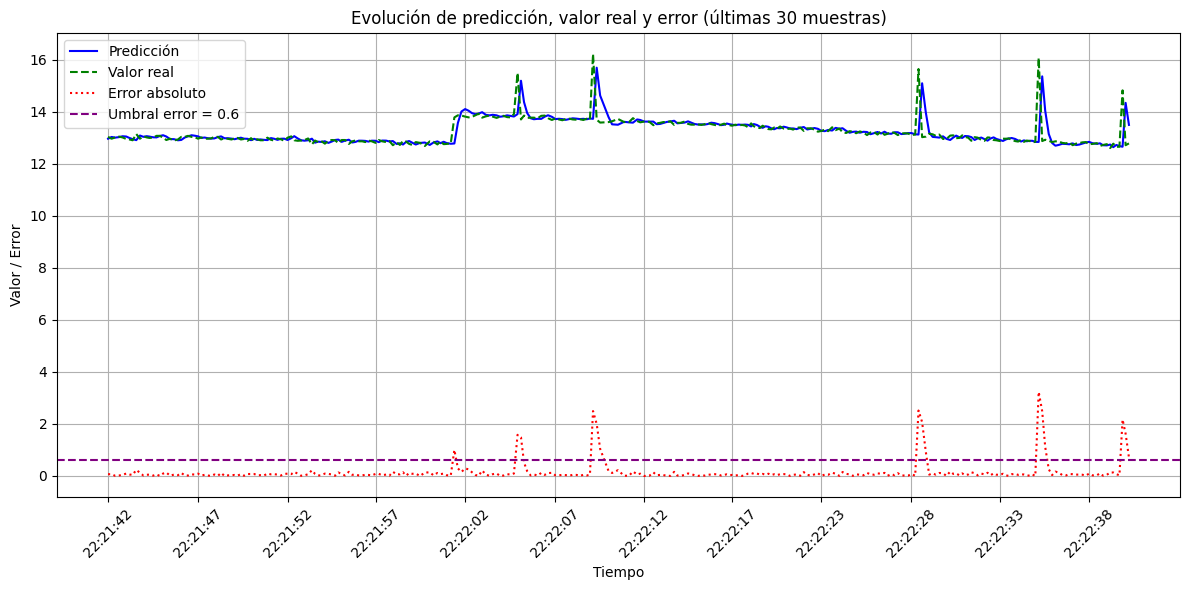


🚨 [ALERTA] Pred:  12.9358 | Real:  12.6100 | Fails: [6] | Err: 0.3258 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.5980 | Real:  12.6800 | Fails: [6] | Err: 0.0820 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.5532 | Real:  12.6800 | Fails: [6] | Err: 0.1268 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.5843 | Real:  12.6500 | Fails: [6] | Err: 0.0657 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.5961 | Real:  12.6500 | Fails: [6] | Err: 0.0539 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.6100 | Real:  12.8000 | Fails: [6] | Err: 0.1900 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.7410 | Real:  12.6300 | Fails: [6] | Err: 0.1110 / Th: (0.6) ✅ -> 

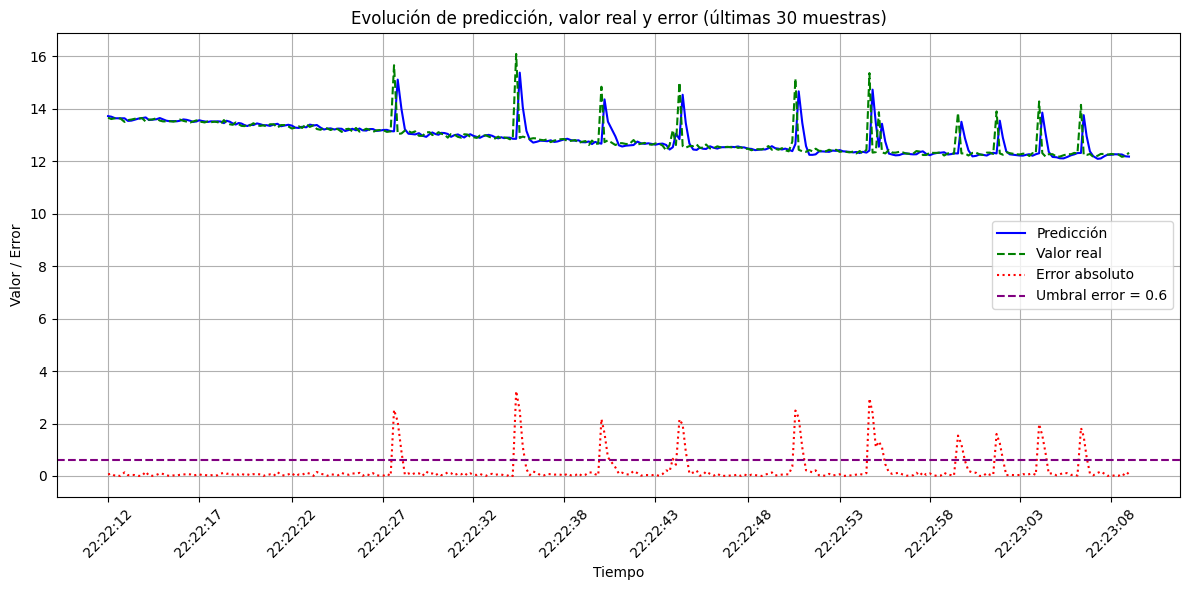


🚨 [ALERTA] Pred:  12.2764 | Real:  12.2300 | Fails: [10] | Err: 0.0464 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.2617 | Real:  12.2600 | Fails: [9] | Err: 0.0017 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.2654 | Real:  12.1900 | Fails: [9] | Err: 0.0754 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.2134 | Real:  12.2500 | Fails: [9] | Err: 0.0366 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.2339 | Real:  12.1900 | Fails: [9] | Err: 0.0439 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.2036 | Real:  13.0800 | Fails: [10] | Err: 0.8764 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.8821 | Real:  12.3100 | Fails: [10] | Err: 0.5721 / Th: (0.6) ✅

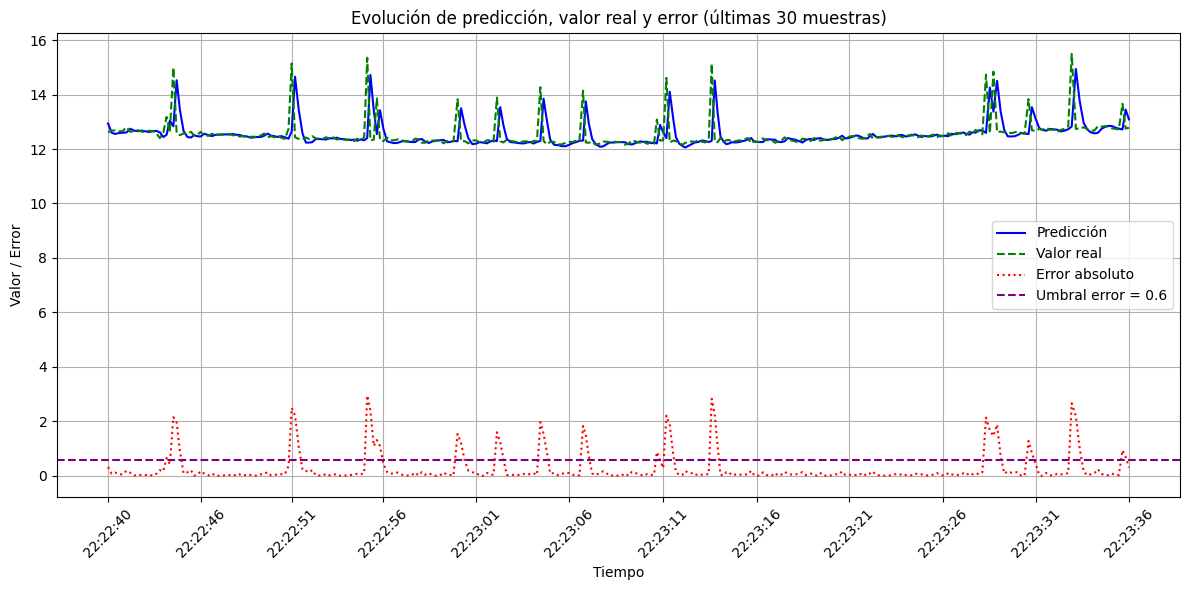


🚨 [ALERTA] Pred:  12.8447 | Real:  12.8100 | Fails: [12] | Err: 0.0347 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.7843 | Real:  12.8500 | Fails: [12] | Err: 0.0657 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.8142 | Real:  14.1000 | Fails: [13] | Err: 1.2858 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.8176 | Real:  12.8300 | Fails: [14] | Err: 0.9876 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.3004 | Real:  12.7800 | Fails: [14] | Err: 0.5204 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.8852 | Real:  12.9400 | Fails: [14] | Err: 0.0548 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.8591 | Real:  12.9200 | Fails: [14] | Err: 0.0609 / Th: (0

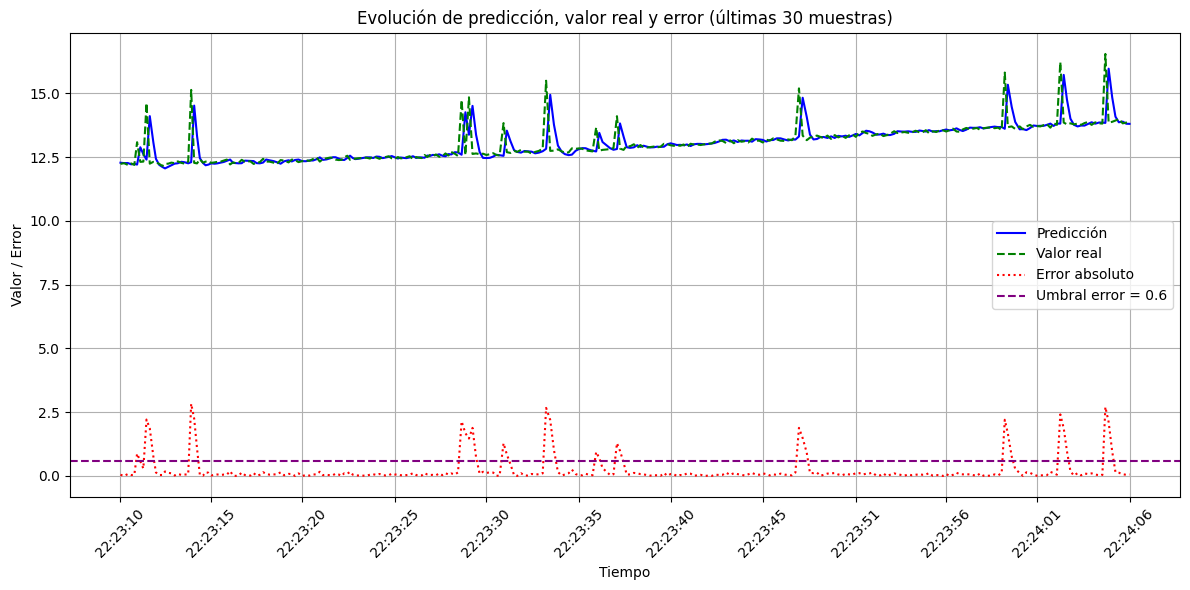


🚨 [ALERTA] Pred:  13.8257 | Real:  13.9200 | Fails: [9] | Err: 0.0943 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.8948 | Real:  13.8800 | Fails: [9] | Err: 0.0148 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.8995 | Real:  13.9200 | Fails: [9] | Err: 0.0205 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.9290 | Real:  13.8600 | Fails: [9] | Err: 0.0690 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.8969 | Real:  13.9900 | Fails: [9] | Err: 0.0931 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.9814 | Real:  17.1000 | Fails: [10] | Err: 3.1186 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  16.4493 | Real:  13.9100 | Fails: [11] | Err: 2.5393 / Th: (0.6) ⚠️

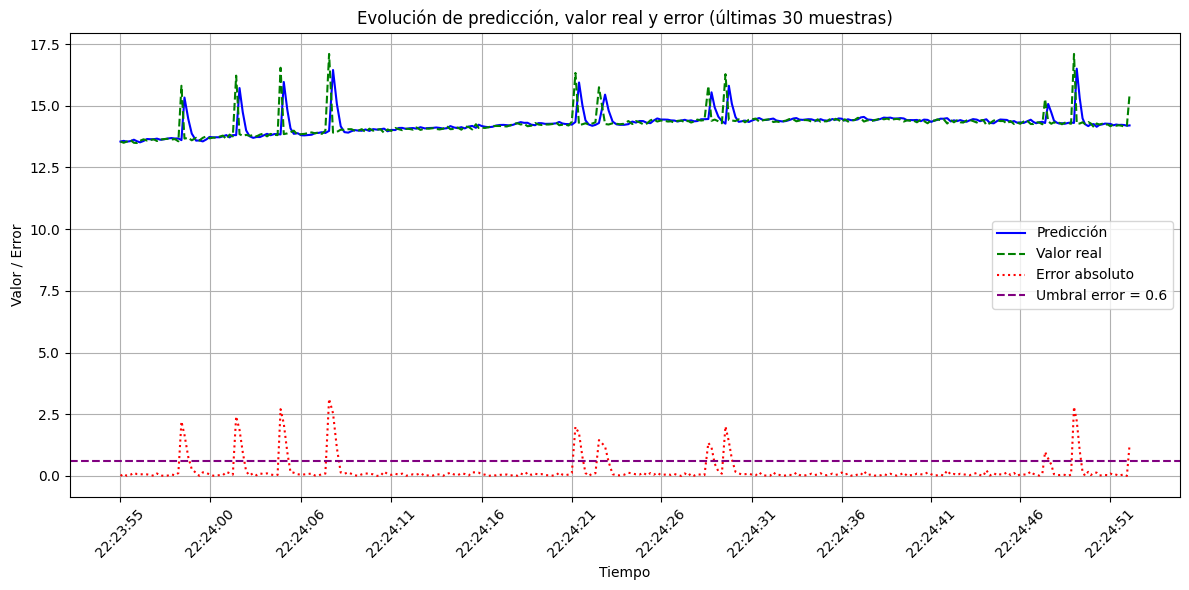


🚨 [ALERTA] Pred:  15.1997 | Real:  14.3200 | Fails: [7] | Err: 0.8797 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  14.7746 | Real:  14.1800 | Fails: [7] | Err: 0.5946 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  14.3438 | Real:  14.2100 | Fails: [7] | Err: 0.1338 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  14.1989 | Real:  14.1200 | Fails: [7] | Err: 0.0789 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  14.1059 | Real:  14.0900 | Fails: [7] | Err: 0.0159 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  14.0620 | Real:  14.1200 | Fails: [7] | Err: 0.0580 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  14.0845 | Real:  14.1800 | Fails: [7] | Err: 0.0955 / Th: (0.6) ✅ ->

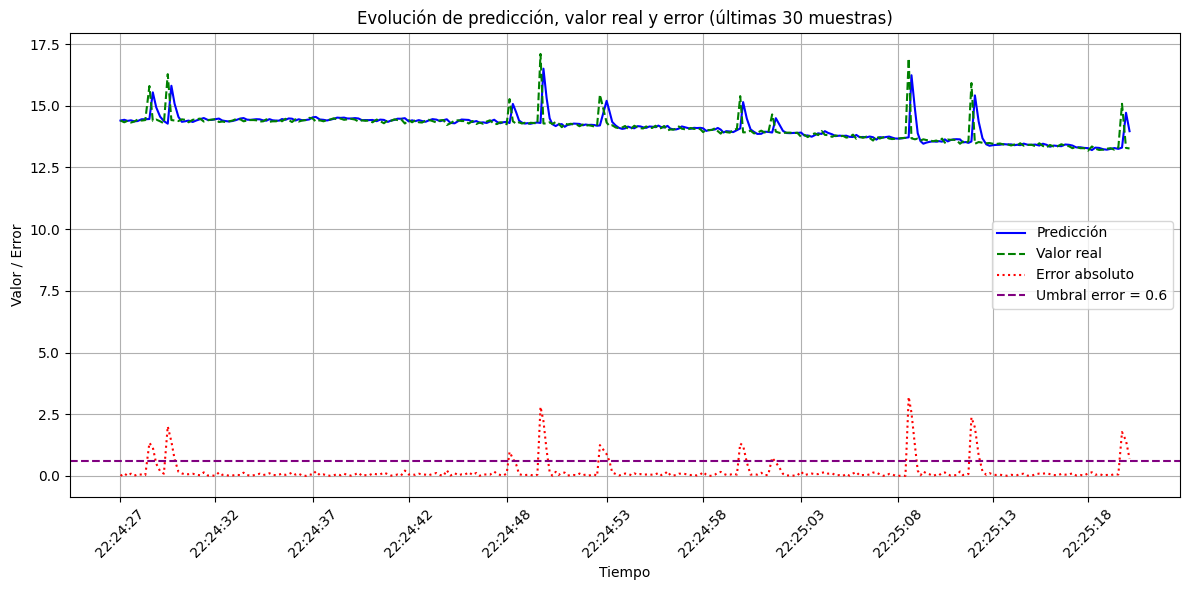


🚨 [ALERTA] Pred:  13.4208 | Real:  13.2500 | Fails: [6] | Err: 0.1708 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.2094 | Real:  13.2200 | Fails: [6] | Err: 0.0106 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.1461 | Real:  13.1900 | Fails: [6] | Err: 0.0439 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.1276 | Real:  13.1900 | Fails: [6] | Err: 0.0624 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.1387 | Real:  13.1800 | Fails: [6] | Err: 0.0413 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.1489 | Real:  13.1200 | Fails: [6] | Err: 0.0289 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.1133 | Real:  14.8000 | Fails: [6] | Err: 1.6867 / Th: (0.6) ⚠️ ->

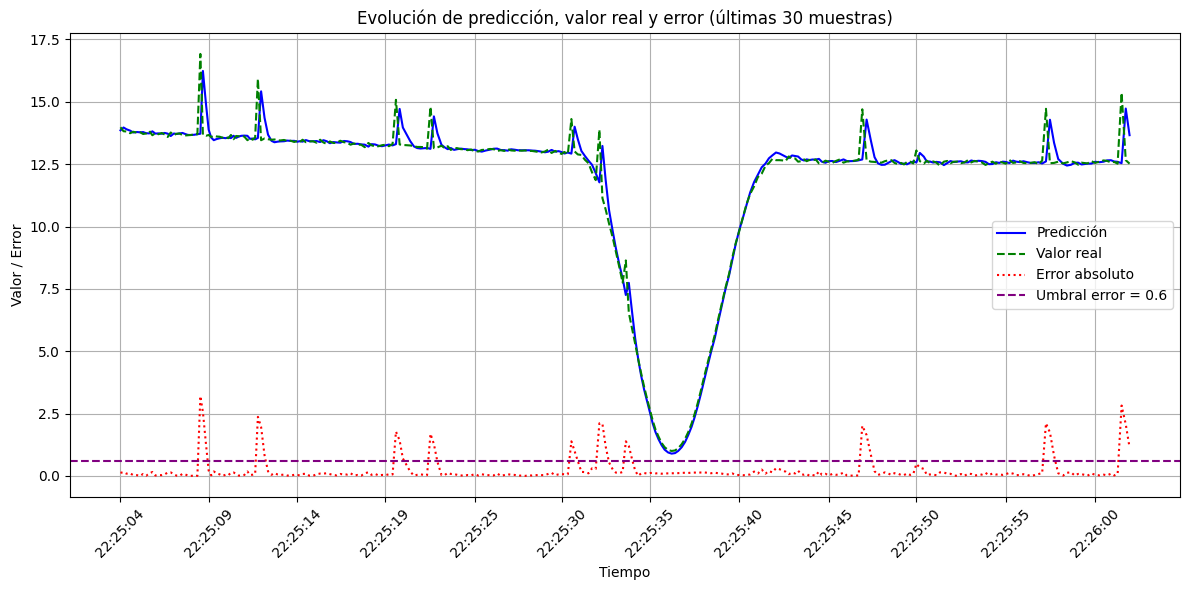


🚨 [ALERTA] Pred:  12.7638 | Real:  12.5200 | Fails: [6] | Err: 0.2438 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.4257 | Real:  12.6400 | Fails: [6] | Err: 0.2143 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.4593 | Real:  12.5200 | Fails: [6] | Err: 0.0607 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.4397 | Real:  12.5800 | Fails: [6] | Err: 0.1403 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.4918 | Real:  12.5900 | Fails: [6] | Err: 0.0982 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  12.5412 | Real:  15.6000 | Fails: [7] | Err: 3.0588 / Th: (0.6) ⚠️ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  14.9148 | Real:  12.6000 | Fails: [8] | Err: 2.3148 / Th: (0.6) ⚠️ -

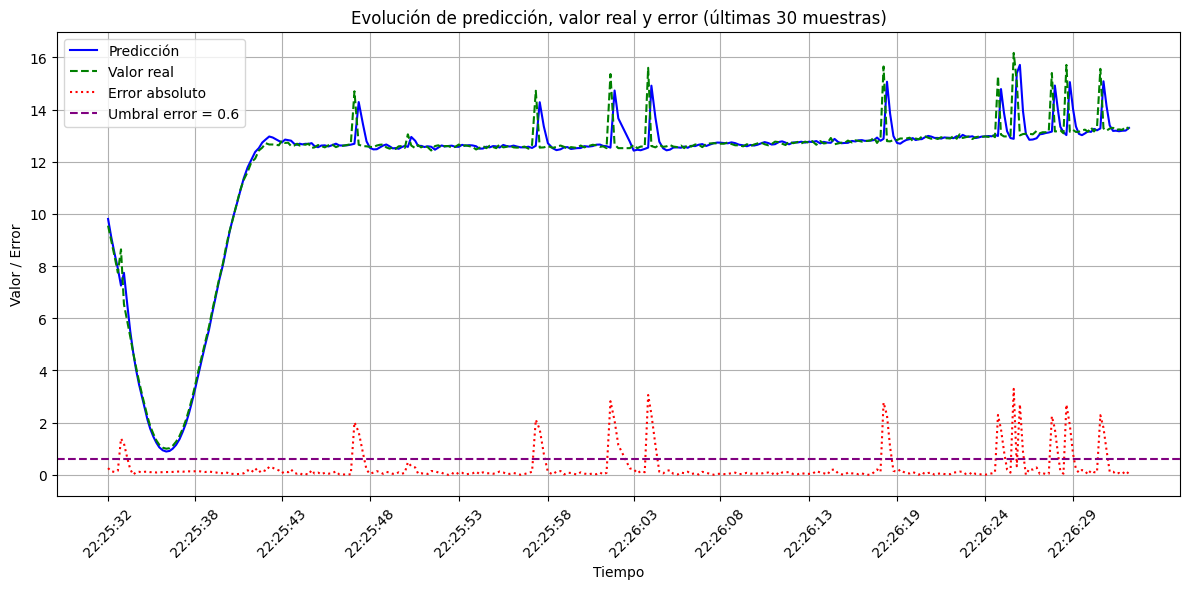


🚨 [ALERTA] Pred:  13.2877 | Real:  13.3000 | Fails: [15] | Err: 0.0123 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.3054 | Real:  13.3200 | Fails: [15] | Err: 0.0146 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.3314 | Real:  13.3800 | Fails: [15] | Err: 0.0486 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.3890 | Real:  13.3400 | Fails: [15] | Err: 0.0490 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.3816 | Real:  13.3000 | Fails: [15] | Err: 0.0816 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.3386 | Real:  13.3300 | Fails: [15] | Err: 0.0086 / Th: (0.6) ✅ -> ERROR: Se supera umbral en ventana de 6 en Ventana de muestras!

🚨 [ALERTA] Pred:  13.3408 | Real:  13.3700 | Fails: [15] | Err: 0.0292 / Th: (0.6

In [2]:
# Selecciona el sensor a monitorear: "Vibracion" o "Corriente"
sensor_a_monitor = "Corriente"  # Cambia a "Vibracion" si se requiere
# Parámetros para evaluar la predicción (error absoluto)
ERROR_ABS_THRESHOLD = 0.6 # Error absoluto mínimo para considerar anomalía
VENTANA_TIEMPO = 50       # Número de muestras consecutivas a evaluar
CANTIDAD_FALLOS = 6       # Mínimo número de fallos en la ventana para emitir alerta

MODEL_PATH = "modelos/18_Corriente_GRU_128_64_0_Ts_60_p87617.h5"
MODEL_TYPE = "GRU"  # Tipo de modelo: "LSTM" o "GRU"
SCALER_PATH = "modelos/scaler-Corriente.pkl"

# Ejecuta el monitoreo para el sensor seleccionado
print(f"Iniciando monitoreo para el sensor: {sensor_a_monitor}")
main(sensor_a_monitor)